In [256]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pandas.core.dtypes.common import is_numeric_dtype

DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

## Unbalanced emozioni

In [289]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

X = MinMaxScaler().fit_transform(  PCA(n_components=20).fit_transform(df[numerical_attr_list]))

ohenc = OneHotEncoder()
y = ohenc.fit_transform( (df["emotion"]=="angry").values.reshape(-1,1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

weights = ((y_train[:, 1] == 1).astype(int) + 1)*32

In [295]:
from keras.layers import Input, Dense , Dropout
from keras.metrics import BinaryCrossentropy, CategoricalCrossentropy, BinaryAccuracy
from keras.losses import BinaryCrossentropy as bce_loss
from keras.models import Model

input = Input(shape=(X.shape[1]), name="input")
dense = Dense(256, activation="relu")(input)
dense = Dense(256, activation="relu")(dense)
dense = Dense(256, activation="relu")(dense)
dense = Dense(256, activation="relu")(dense)

output = Dense(y.shape[1], activation="softmax", name="output")(dense)

model = Model(inputs=input, outputs=output, name="DenseNetwork")
model.compile(optimizer="adam",
            loss=bce_loss(from_logits=False),
            metrics= [BinaryCrossentropy(from_logits=False), BinaryAccuracy()],
            weighted_metrics=[BinaryCrossentropy(from_logits=False), BinaryAccuracy()])
model.summary()

Model: "DenseNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 20)]              0         
                                                                 
 dense_56 (Dense)            (None, 256)               5376      
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dense_58 (Dense)            (None, 256)               65792     
                                                                 
 dense_59 (Dense)            (None, 256)               65792     
                                                                 
 output (Dense)              (None, 2)                 514       
                                                                 
Total params: 203,266
Trainable params: 203,266
Non-tr

In [296]:
history = model.fit(X_train, y_train, sample_weight=weights, 
                    epochs=35, batch_size=10, verbose=1, 
                    validation_split = 0.02)

Epoch 1/35
191/191 [==============================] - 5s 12ms/step - loss: 20.0798 - binary_crossentropy: 0.4428 - binary_accuracy: 0.8419 - weighted_binary_crossentropy: 0.5438 - weighted_binary_accuracy: 0.7456 - val_loss: 29.9546 - val_binary_crossentropy: 0.5418 - val_binary_accuracy: 0.7179 - val_weighted_binary_crossentropy: 0.7158 - val_weighted_binary_accuracy: 0.5686
Epoch 2/35
191/191 [==============================] - 2s 9ms/step - loss: 17.0248 - binary_crossentropy: 0.3717 - binary_accuracy: 0.8566 - weighted_binary_crossentropy: 0.4611 - weighted_binary_accuracy: 0.7943 - val_loss: 35.7859 - val_binary_crossentropy: 0.6021 - val_binary_accuracy: 0.6923 - val_weighted_binary_crossentropy: 0.8552 - val_weighted_binary_accuracy: 0.5490
Epoch 3/35
191/191 [==============================] - 2s 10ms/step - loss: 16.2769 - binary_crossentropy: 0.3618 - binary_accuracy: 0.8577 - weighted_binary_crossentropy: 0.4408 - weighted_binary_accuracy: 0.8043 - val_loss: 24.2661 - val_bina

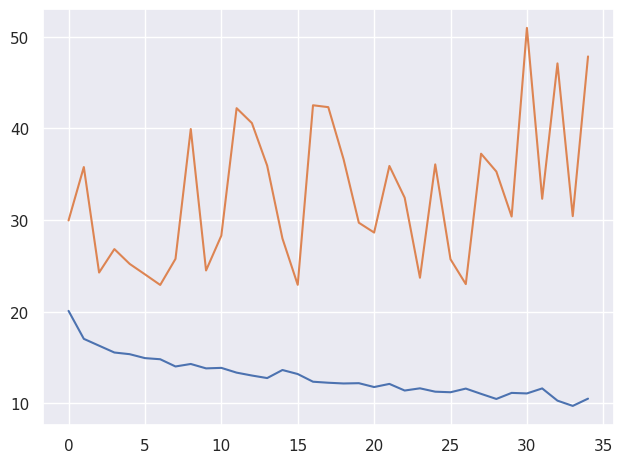

In [297]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

4/4 [==============================] - 0s 3ms/step
[[9.9997991e-01 2.0021656e-05]
 [9.9999994e-01 5.0691482e-11]
 [8.4573364e-01 1.5426636e-01]
 [1.3980272e-02 9.8601967e-01]
 [4.4272531e-02 9.5572740e-01]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


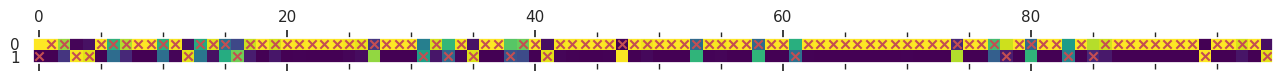

In [298]:
who = np.random.randint(len(y_test),size=100)
predictions=model.predict(X_test[who,:])
plt.matshow(predictions.T, cmap = "viridis")
plt.scatter( np.arange(len(who)), np.argmax(y_test[who], axis=-1), marker="x", color="r")
plt.grid("")

print(predictions[:5])
print(y_test[who][:5])

In [299]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(ohenc.inverse_transform(y_test), ohenc.inverse_transform(y_pred)))

16/16 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       False       0.93      0.94      0.93       419
        True       0.59      0.54      0.56        67

    accuracy                           0.88       486
   macro avg       0.76      0.74      0.75       486
weighted avg       0.88      0.88      0.88       486



In [309]:
from umap import UMAP
reducer = UMAP(n_components=2, n_neighbors=50)
embedding = reducer.fit_transform(X)

In [310]:
N_points = 60
xx = np.linspace(np.min(embedding[:, 0]), np.max(embedding[:,0]), N_points)
yy = np.linspace(np.min(embedding[:, 1]), np.max(embedding[:,1]), N_points)
xx, yy = np.meshgrid(xx, yy)
points = np.stack((xx, yy)).T.reshape(-1,2)
points_expanded = reducer.inverse_transform(points)
expected_class = model.predict(points_expanded)[:, 1]

113/113 [==============================] - 0s 4ms/step


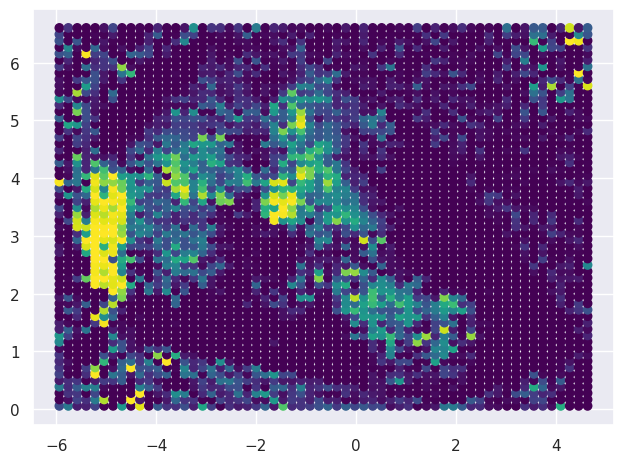

In [311]:
plt.scatter(*points.T, c=expected_class, cmap="viridis",)

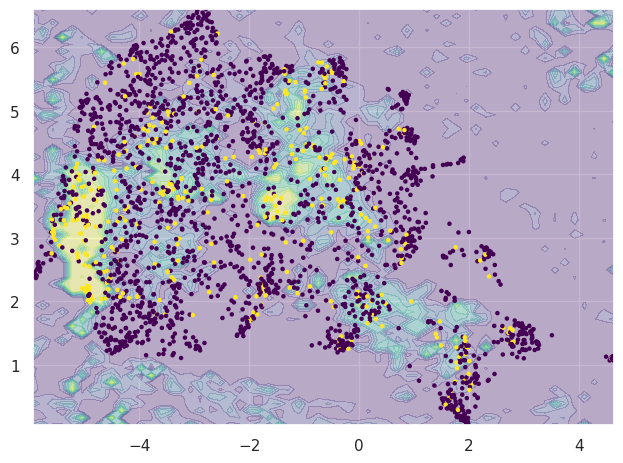

In [312]:
plt.contourf(xx, yy, np.rot90(expected_class.reshape(-1, N_points).T, k=0), alpha=0.3, cmap="viridis", levels=10)
plt.scatter(*embedding.T, c=ohenc.inverse_transform(y), cmap="viridis", s= 5)